# COCO → Skyless Assignment


**What’s included**
- Downloads **COCO val2017** (images + `instances_val2017.json`)
- COCO subset builder (outdoor categories)
- Detectron2 predictors (Mask R-CNN + Panoptic FPN)
- Instance vs Panoptic side-by-side demo
- Mask R-CNN demo on random images
- Robust skyline detection + full skyless conversion with re-annotated COCO JSON
- Visual validators and saved side-by-side pairs
- Lightweight README generator


# 0) Mount Drive (Colab)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 0) Runtime & environment notes — Install dependencies

In [3]:

%%bash
pip -q install opencv-python pycocotools tqdm numpy pillow pyyaml matplotlib
pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121 || true
pip -q install 'git+https://github.com/facebookresearch/detectron2.git' || true
python - << 'PY'
import torch, torchvision, sys
print('Torch:', torch.__version__, ' CUDA:', torch.version.cuda)
print('Torchvision:', torchvision.__version__)
print('Python:', sys.version)
PY

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.0 MB/s eta 0:00:00
Torch: 2.8.0+cu126  CUDA: 12.6
Torchvision: 0.23.0+cu126
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


## 1) Project folders

In [4]:
import os, json, shutil, random
import numpy as np
import torch

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior in cuDNN (may reduce speed a bit)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

BASE = '/content/drive/MyDrive/coco-skyless'
os.makedirs(BASE, exist_ok=True)

DIRS = {
    'coco_images':     f'{BASE}/data/coco/images/val2017',
    'coco_anns':       f'{BASE}/data/coco/annotations',
    'subset_images':   f'{BASE}/data/subset/images',
    'subset_anns':     f'{BASE}/data/subset/annotations',
    'skyless_images':  f'{BASE}/data/skyless/images',
    'skyless_anns':    f'{BASE}/data/skyless/annotations',
    'outputs':         f'{BASE}/outputs',
    # Explicit outputs subfolders
    'outputs_instances_demo': f'{BASE}/outputs/instances_demo',
    'outputs_pairs':          f'{BASE}/outputs/pairs',
}

for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

# Convenience variables
pairs_dir = DIRS['outputs_pairs']
demo_out  = DIRS['outputs_instances_demo']

print('Base:', BASE)
DIRS


Base: /content/drive/MyDrive/coco-skyless


{'coco_images': '/content/drive/MyDrive/coco-skyless/data/coco/images/val2017',
 'coco_anns': '/content/drive/MyDrive/coco-skyless/data/coco/annotations',
 'subset_images': '/content/drive/MyDrive/coco-skyless/data/subset/images',
 'subset_anns': '/content/drive/MyDrive/coco-skyless/data/subset/annotations',
 'skyless_images': '/content/drive/MyDrive/coco-skyless/data/skyless/images',
 'skyless_anns': '/content/drive/MyDrive/coco-skyless/data/skyless/annotations',
 'outputs': '/content/drive/MyDrive/coco-skyless/outputs',
 'outputs_instances_demo': '/content/drive/MyDrive/coco-skyless/outputs/instances_demo',
 'outputs_pairs': '/content/drive/MyDrive/coco-skyless/outputs/pairs'}

## 2) Download COCO val2017 (images + annotations)
This block downloads ZIPs and places them under your Drive project structure.

In [5]:
%%bash
set -e                                # Stop execution immediately if any command fails
cd /content/drive/MyDrive             # Go to Colab’s working directory

# Download COCO 2017 validation images (if not already downloaded)
if [ ! -f val2017.zip ]; then
  wget -q http://images.cocodataset.org/zips/val2017.zip
fi

# Download COCO 2017 annotations (if not already downloaded)
if [ ! -f annotations_trainval2017.zip ]; then
  wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
fi

# Unzip the validation images into folder "val2017_all/"
unzip -oq val2017.zip -d val2017_all

# Unzip the annotations into folder "anns_all/"
unzip -oq annotations_trainval2017.zip -d anns_all

# Create target directories inside Google Drive for images and annotations
mkdir -p /content/drive/MyDrive/coco-skyless/data/coco/images
mkdir -p /content/drive/MyDrive/coco-skyless/data/coco/annotations

# Move the "val2017" image folder into the Google Drive dataset folder
mv -f val2017_all/val2017 /content/drive/MyDrive/coco-skyless/data/coco/images/ || true

# Copy the "instances_val2017.json" annotations file into Google Drive
cp -f anns_all/annotations/instances_val2017.json /content/drive/MyDrive/coco-skyless/data/coco/annotations/


## 3) Build a small *outdoor* subset

In [6]:
from pycocotools.coco import COCO

# Maximum number of images to keep in the subset
MAX_IMAGES = 200

# Paths to original COCO annotations and images
instances_json = f"{DIRS['coco_anns']}/instances_val2017.json"
images_dir = DIRS['coco_images']

# Paths to output subset (images + annotations)
out_images_dir = DIRS['subset_images']
out_json = f"{DIRS['subset_anns']}/instances_subset.json"

# Load the COCO annotations using COCO API
coco = COCO(instances_json)

# Define "outdoor" categories we are interested in
outdoor_cats = [
    'car','bus','truck','bicycle','motorcycle',
    'train','stop sign','traffic light','bench','bird'
]

# Get category IDs for those outdoor categories
cat_ids = coco.getCatIds(catNms=outdoor_cats)

# Collect all image IDs that contain at least one of those categories
img_ids = set()
for cid in cat_ids:
    img_ids.update(coco.getImgIds(catIds=[cid]))
img_ids = list(img_ids)

# Shuffle randomly and limit to MAX_IMAGES
random.shuffle(img_ids)
img_ids = img_ids[:MAX_IMAGES]

# Load image metadata for the selected IDs
imgs = coco.loadImgs(img_ids)

# Make sure output folder for subset images exists
os.makedirs(out_images_dir, exist_ok=True)

# Copy the selected images into the subset folder
copied = 0
for im in imgs:
    src = os.path.join(images_dir, im['file_name'])
    dst = os.path.join(out_images_dir, im['file_name'])
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copy2(src, dst)
    copied += 1
print('Copied images:', copied)

# Build new annotations JSON for the subset
anns_out = {
    'images': imgs,
    'annotations': [a for a in coco.dataset['annotations'] if a['image_id'] in img_ids],
    'categories': coco.dataset['categories']
}

with open(out_json, 'w') as f:
    json.dump(anns_out, f, indent=2)

print('Wrote subset annotations to', out_json)


loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
Copied images: 200
Wrote subset annotations to /content/drive/MyDrive/coco-skyless/data/subset/annotations/instances_subset.json


## 4) Detectron2 predictors

In [7]:
import cv2, glob
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode

def build_instance_predictor(score_thresh=0.5):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml')
    return DefaultPredictor(cfg)

def build_panoptic_predictor():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file('COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml'))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml')
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.3
    return DefaultPredictor(cfg)

def get_coco_panoptic_metadata():
    """Returns COCO panoptic metadata with stuff classes if available."""
    for key in ("coco_2017_val_panoptic_separated", "coco_2017_val_panoptic"):
        try:
            m = MetadataCatalog.get(key)
            if getattr(m, 'stuff_classes', None):
                return m
        except KeyError:
            pass
    return None

inst_pred = build_instance_predictor()
pan_pred = build_panoptic_predictor()
print('Predictors ready.')


model_final_f10217.pkl: 178MB [00:00, 194MB/s]                           
model_final_cafdb1.pkl: 261MB [00:01, 259MB/s]                           


Predictors ready.


### Why both Instance and Panoptic?

Instance segmentation demonstrates object-level detection (things). Panoptic segmentation includes both **things** and **stuff** (e.g., sky), which we need for skyline detection and sky removal.

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


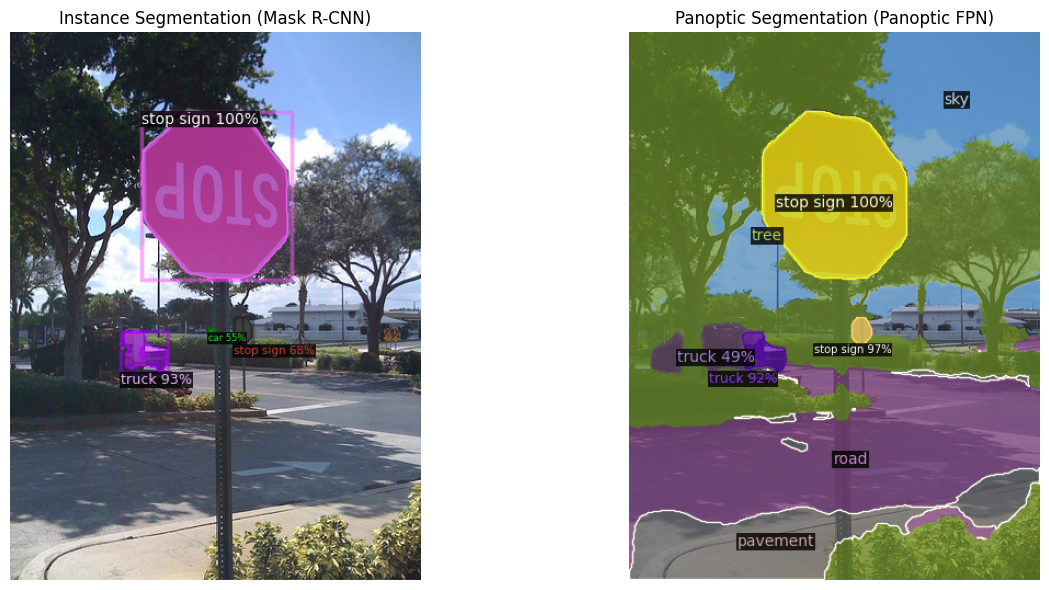

Saved side-by-side to: /content/drive/MyDrive/coco-skyless/outputs/instance_vs_panoptic.png


In [8]:
# === Side-by-side: Instance vs Panoptic ===
import os
import numpy as np
import matplotlib.pyplot as plt

def instance_panoptic_comparison(image_path, out_path=None, score_thresh=None):
    """
    Runs Mask R-CNN (instance) and Panoptic FPN (panoptic) on the same image and
    shows a side-by-side comparison. Optionally saves the combined figure.
    """
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    img_rgb = img_bgr[:, :, ::-1]

    if score_thresh is not None:
        inst_pred.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = float(score_thresh)

    inst_out = inst_pred(img_bgr)
    pano_out = pan_pred(img_bgr)
    pan_seg, segments_info = pano_out["panoptic_seg"]

    meta = get_coco_panoptic_metadata()

    v1 = Visualizer(img_rgb.copy(), metadata=meta, instance_mode=ColorMode.IMAGE)
    inst_vis = v1.draw_instance_predictions(inst_out["instances"].to("cpu")).get_image()

    v2 = Visualizer(img_rgb.copy(), metadata=meta, instance_mode=ColorMode.IMAGE)
    pano_vis = v2.draw_panoptic_seg_predictions(pan_seg.to("cpu"), segments_info).get_image()

    fig = plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1); plt.title("Instance Segmentation (Mask R-CNN)")
    plt.imshow(inst_vis); plt.axis("off")
    plt.subplot(1, 2, 2); plt.title("Panoptic Segmentation (Panoptic FPN)")
    plt.imshow(pano_vis); plt.axis("off")
    plt.tight_layout()
    plt.show()

    if out_path is not None:
        combo = np.hstack([inst_vis, pano_vis])[:, :, ::-1]
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        cv2.imwrite(out_path, combo)
        print(f"Saved side-by-side to: {out_path}")

# Example usage (guarded):
_subset_files = sorted(os.listdir(DIRS["subset_images"]))
if _subset_files:
    example_img = _subset_files[0]
    example_path = os.path.join(DIRS["subset_images"], example_img)
    instance_panoptic_comparison(
        image_path=example_path,
        out_path=os.path.join(DIRS["outputs"], "instance_vs_panoptic.png"),
        score_thresh=0.5
    )
else:
    print("No images found in subset. Skipping instance_panoptic_comparison().")


## 5) Inference demo (Mask R-CNN)

In [9]:
import numpy as np

paths = glob.glob(f"{DIRS['subset_images']}/*.jpg")
random.shuffle(paths)

for p in paths[:6]:
    img = cv2.imread(p)
    out = inst_pred(img)
    v = Visualizer(img[:, :, ::-1], metadata=None, instance_mode=ColorMode.IMAGE)
    drawn = v.draw_instance_predictions(out['instances'].to('cpu')).get_image()
    drawn = drawn[:, :, ::-1]
    cv2.imwrite(os.path.join(demo_out, os.path.basename(p)), drawn)

demo_out


'/content/drive/MyDrive/coco-skyless/outputs/instances_demo'

## 6) Skyline detection helper

In [10]:
import numpy as np
from detectron2.data import MetadataCatalog

def find_lowest_sky_row(panoptic_pred, sky_name='sky'):
    pan_seg, seg_info = panoptic_pred['panoptic_seg']
    pan = pan_seg.cpu().numpy()

    meta = get_coco_panoptic_metadata()
    stuff_classes = getattr(meta, 'stuff_classes', None)

    h, w = pan.shape
    sky_mask = np.zeros((h, w), dtype=np.uint8)

    for s in seg_info:
        if not s.get('isthing', False):
            cid = s['category_id']
            name = None
            if stuff_classes and cid < len(stuff_classes):
                name = stuff_classes[cid]
            if name == sky_name:
                sky_mask[pan == s['id']] = 1

    ys = np.where(sky_mask)[0]
    return int(ys.max()) if ys.size else None


## 7) Crop & re-annotate COCO (skyless conversion)

In [11]:
from tqdm import tqdm
from pycocotools import mask as maskUtils

def rle_or_poly_to_mask(ann, height, width):
    """
    Robustly decode COCO segmentation that might be:
      - polygons (list of [x1,y1,...])
      - compressed RLE (dict with 'counts' as bytes/str)
      - uncompressed RLE (dict with 'counts' as list)
    Returns a uint8 mask of shape (H, W) or None.
    """
    seg = ann.get("segmentation", None)
    if seg is None:
        return None
    if isinstance(seg, list):
        if len(seg) == 0:
            return None
        rles = maskUtils.frPyObjects(seg, height, width)
        rle = maskUtils.merge(rles) if isinstance(rles, list) else rles
        return maskUtils.decode(rle).astype(np.uint8)
    if isinstance(seg, dict):
        counts = seg.get("counts", None)
        if isinstance(counts, list):
            rle = maskUtils.frPyObjects(seg, height, width)
            rle = maskUtils.merge(rle) if isinstance(rle, list) else rle
            return maskUtils.decode(rle).astype(np.uint8)
        return maskUtils.decode(seg).astype(np.uint8)
    return None

def mask_to_rle(mask):
    rle = maskUtils.encode(np.asfortranarray(mask))
    rle['counts'] = rle['counts'].decode('ascii')
    return rle

def adjust_bbox(bbox, y_cut, new_h):
    x, y, w, h = bbox
    y2 = y + h
    y_new = y - y_cut
    y1c = max(0, y_new)
    y2c = min(new_h, y2 - y_cut)
    h_new = y2c - y1c
    if h_new <= 0:
        return None
    return [float(x), float(y1c), float(w), float(h_new)]

def build_y_finder(pan_pred):
    def fn(img_bgr):
        out = pan_pred(img_bgr)
        return find_lowest_sky_row(out)
    return fn

def process_dataset(images_dir, in_json, out_images_dir, out_json, y_find_fn, min_keep_height=10):
    os.makedirs(out_images_dir, exist_ok=True)
    with open(in_json, 'r') as f:
        data = json.load(f)

    anns_by_img = {}
    for a in data['annotations']:
        anns_by_img.setdefault(a['image_id'], []).append(a)

    new_images, new_annotations = [], []
    new_ann_id = 1
    report = []

    for img in tqdm(data['images']):
        img_path = os.path.join(images_dir, img['file_name'])
        im = cv2.imread(img_path)
        if im is None:
            continue
        H, W = im.shape[:2]

        y_cut = y_find_fn(im)
        no_sky = False
        if y_cut is None:
            y_cut = -1
            no_sky = True

        start = min(H, y_cut + 1)
        im_cropped = im[start:H, :, :]
        Hn = im_cropped.shape[0]

        if Hn < min_keep_height:
            report.append({'file': img['file_name'], 'status': 'skip_small', 'cut': int(y_cut)})
            continue

        out_path = os.path.join(out_images_dir, img['file_name'])
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        cv2.imwrite(out_path, im_cropped)

        new_img = dict(img)
        new_img['height'] = int(Hn)
        new_img['width']  = int(W)
        new_images.append(new_img)

        kept = 0
        for ann in anns_by_img.get(img['id'], []):
            new_bbox = adjust_bbox(ann['bbox'], start, Hn)
            if new_bbox is None:
                continue

            seg_mask = rle_or_poly_to_mask(ann, H, W)
            if seg_mask is not None:
                seg_cropped = seg_mask[start:H, :]
                if seg_cropped.sum() == 0:
                    continue
                new_seg = mask_to_rle(seg_cropped)
                new_area = float(seg_cropped.sum())
            else:
                new_seg = ann.get('segmentation', None)
                new_area = float(new_bbox[2] * new_bbox[3])

            new_ann = dict(ann)
            new_ann['id'] = new_ann_id; new_ann_id += 1
            new_ann['bbox'] = new_bbox
            new_ann['segmentation'] = new_seg
            new_ann['area'] = new_area
            new_annotations.append(new_ann)
            kept += 1

        report.append({
            'file': img['file_name'],
            'status': 'ok' if kept > 0 else ('no_anns' if not no_sky else 'no_sky'),
            'cut': int(y_cut),
            'kept_anns': kept
        })

    new_data = {
        'images': new_images,
        'annotations': new_annotations,
        'categories': data['categories']
    }

    with open(out_json, 'w') as f:
        json.dump(new_data, f, indent=2)

    return report


## 8) Run the skyless conversion and summarize report

In [12]:
subset_json = f"{DIRS['subset_anns']}/instances_subset.json"
out_json = f"{DIRS['skyless_anns']}/instances_skyless.json"
y_finder = build_y_finder(pan_pred)
report = process_dataset(DIRS['subset_images'], subset_json, DIRS['skyless_images'], out_json, y_finder)
print('Wrote', out_json)
len(report)

import pandas as pd
from collections import Counter

df_report = pd.DataFrame(report)
status_counts = df_report['status'].value_counts()
avg_cut = df_report['cut'].mean()
avg_kept = df_report['kept_anns'].mean()

print("=== Report Summary ===")
print(status_counts)
print(f"\nAverage cut row: {avg_cut:.1f}")
print(f"Average kept annotations per image: {avg_kept:.2f}")
df_report.head()


100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


Wrote /content/drive/MyDrive/coco-skyless/data/skyless/annotations/instances_skyless.json
=== Report Summary ===
status
ok            198
skip_small      2
Name: count, dtype: int64

Average cut row: 103.7
Average kept annotations per image: 8.77


,file,status,cut,kept_anns
0,000000130826.jpg,ok,-1,9.0
1,000000479030.jpg,ok,33,12.0
2,000000578093.jpg,ok,-1,5.0
3,000000227898.jpg,ok,-1,8.0
4,000000066135.jpg,ok,-1,1.0


## 9) Visual validation (original vs cropped + new annotations)

In [13]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import numpy as np
import cv2
import os

def show_all_examples(orig_img_dir, orig_json, new_img_dir, new_json, limit=None):
    coco_old = COCO(orig_json)
    coco_new = COCO(new_json)
    ids = [im['id'] for im in coco_new.dataset['images']]
    if len(ids) == 0:
        print('No images in new dataset.')
        return
    ids = sorted(ids)
    if limit is not None:
        ids = ids[:limit]
    for iid in ids:
        new_im = coco_new.loadImgs([iid])[0]
        old_im = next((im for im in coco_old.dataset['images']
                       if im['file_name'] == new_im['file_name']), None)
        if old_im is None:
            continue
        img_old = cv2.imread(os.path.join(orig_img_dir, old_im['file_name']))[:, :, ::-1]
        img_new = cv2.imread(os.path.join(new_img_dir, new_im['file_name']))[:, :, ::-1]
        ann_ids = coco_new.getAnnIds(imgIds=[iid])
        anns = coco_new.loadAnns(ann_ids)
        overlay = img_new.copy()
        for a in anns:
            if a.get('segmentation') is not None:
                try:
                    m = maskUtils.decode(a['segmentation']).astype(bool)
                    overlay[m] = (overlay[m] * 0.4 + np.array([255, 0, 0]) * 0.6).astype(np.uint8)
                except Exception:
                    pass
            x, y, w, h = map(int, a['bbox'])
            cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 255, 0), 2)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.title('Original'); plt.imshow(img_old); plt.axis('off')
        plt.subplot(1, 2, 2); plt.title('Skyless + New Anns'); plt.imshow(overlay); plt.axis('off')
        plt.show()

subset_json = f"{DIRS['subset_anns']}/instances_subset.json"
skyless_json = f"{DIRS['skyless_anns']}/instances_skyless.json"
show_all_examples(DIRS['subset_images'], subset_json, DIRS['skyless_images'], skyless_json, limit=None)


Output hidden; open in https://colab.research.google.com to view.

### Save side-by-side image pairs (Original vs Skyless + new annotations)

In [14]:
from pycocotools.coco import COCO

def save_side_by_side_pairs(
    orig_img_dir,
    orig_json,
    new_img_dir,
    new_json,
    out_dir,
    limit=None,
    draw_masks=True,
    draw_boxes=True,
    draw_labels=True
):
    os.makedirs(out_dir, exist_ok=True)
    coco_old = COCO(orig_json)
    coco_new = COCO(new_json)
    cat_id_to_name = {c['id']: c['name'] for c in coco_new.loadCats(coco_new.getCatIds())}
    ids = [im['id'] for im in coco_new.dataset['images']]
    ids = sorted(ids)
    if limit is not None:
        ids = ids[:limit]
    saved = 0
    for iid in ids:
        new_im = coco_new.loadImgs([iid])[0]
        old_im = next((im for im in coco_old.dataset['images']
                       if im['file_name'] == new_im['file_name']), None)
        if old_im is None:
            continue
        left_bgr  = cv2.imread(os.path.join(orig_img_dir, old_im['file_name']))
        right_bgr = cv2.imread(os.path.join(new_img_dir,  new_im['file_name']))
        if left_bgr is None or right_bgr is None:
            continue
        overlay = right_bgr.copy()
        ann_ids = coco_new.getAnnIds(imgIds=[iid])
        anns = coco_new.loadAnns(ann_ids)
        for a in anns:
            if draw_masks and a.get('segmentation') is not None:
                try:
                    m = maskUtils.decode(a['segmentation']).astype(bool)
                    overlay[m] = (overlay[m] * 0.4 + np.array([0, 0, 255]) * 0.6).astype(np.uint8)
                except Exception:
                    pass
            if draw_boxes:
                x, y, w, h = map(int, a['bbox'])
                cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)
            if draw_labels:
                cls = cat_id_to_name.get(a['category_id'], "unknown")
                x, y, w, h = map(int, a['bbox'])
                yy = max(y - 5, 15)
                cv2.putText(
                    overlay, cls, (x, yy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2, lineType=cv2.LINE_AA
                )
        hL, wL = left_bgr.shape[:2]
        hR, wR = overlay.shape[:2]
        H = max(hL, hR)
        def pad_to_h(img, H):
            if img.shape[0] == H:
                return img
            pad_top = 0
            pad_bot = H - img.shape[0]
            return cv2.copyMakeBorder(img, pad_top, pad_bot, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
        left_pad  = pad_to_h(left_bgr, H)
        right_pad = pad_to_h(overlay, H)
        pair = np.hstack([left_pad, right_pad])
        cv2.putText(pair, "Original", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (240,240,240), 2)
        cv2.putText(pair, "Skyless + New Annotations", (wL + 10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (240,240,240), 2)
        base = os.path.splitext(new_im['file_name'])[0] + "_pair.jpg"
        out_path = os.path.join(out_dir, base)
        cv2.imwrite(out_path, pair)
        saved += 1
    print(f"Saved {saved} side-by-side pairs to: {out_dir}")

subset_json  = f"{DIRS['subset_anns']}/instances_subset.json"
skyless_json = f"{DIRS['skyless_anns']}/instances_skyless.json"
save_side_by_side_pairs(
    orig_img_dir=DIRS['subset_images'],
    orig_json=subset_json,
    new_img_dir=DIRS['skyless_images'],
    new_json=skyless_json,
    out_dir=pairs_dir,
    limit=None
)


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Saved 198 side-by-side pairs to: /content/drive/MyDrive/coco-skyless/outputs/pairs


## 10) Save a lightweight README

In [15]:
import datetime, pytz
os.makedirs(BASE, exist_ok=True)
now = datetime.datetime.now(pytz.timezone("America/Toronto")).strftime("%Y-%m-%d %H:%M")
content = f"""# COCO → Skyless Dataset (Detectron2)

Create a **skyless** version of a COCO dataset split: automatically detect the **sky**, crop it out, and **rebuild COCO annotations** (bboxes, masks, areas). Includes inference demos, validation views, and a short report.

## Overview
- Downloads **COCO val2017** (images + `instances_val2017.json`).
- Builds a small **outdoor** subset (configurable).
- Runs **panoptic segmentation** to localize *sky* and crops **below the lowest sky pixel** (the skyline).
- **Re-annotates** the dataset (bbox/masks/areas) in valid COCO format.
- Validates with:
  - **Mask R-CNN** demo overlays.
  - Side-by-side views (original vs skyless) with updated annotations.
  - A compact **processing report** (success/skip/no-sky, etc.).

## Environment
- **Notebook:** Google Colab (GPU recommended; CPU works for small subsets)
- **Core libs:** `detectron2`, `torch/torchvision`, `opencv-python`, `pycocotools`, `numpy`, `matplotlib`, `tqdm`, `pandas`
- **Tested with:** Torch 2.8.x, CUDA 12.x, Python 3.12 (Colab)

## Data & Folder Layout
Default root: `BASE={BASE}`
coco-skyless/
├─ data/
│  ├─ coco/
│  │  ├─ images/val2017/
│  │  └─ annotations/instances_val2017.json
│  ├─ subset/
│  │  ├─ images/
│  │  └─ annotations/instances_subset.json
│  └─ skyless/
│     ├─ images/
│     └─ annotations/instances_skyless.json
└─ outputs/
   ├─ instances_demo/
   └─ pairs/

## Quickstart (Colab)
1. Change runtime to GPU (optional).
2. Run cells in order: install → folders → download COCO → subset → predictors → demos → skyless conversion → validators → report.

## Models & Why Both
- **Instance** (Mask R-CNN): object-level demos.
- **Panoptic** (Panoptic FPN): sky detection (stuff class) for cropping.

---
*Generated: {now} by Sakineh Abdollahzadeh*
"""
with open(f"{BASE}/README.md", "w", encoding="utf-8") as f:
    f.write(content)
print(f"README saved to {BASE}/README.md")


README saved to /content/drive/MyDrive/coco-skyless/README.md
